##### Copyright 2019 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural machine translation with attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/nmt_with_attention.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook trains a sequence to sequence (seq2seq) model for Spanish to English translation. This is an advanced example that assumes some knowledge of sequence to sequence models.

After training the model in this notebook, you will be able to input a Spanish sentence, such as *"¿todavia estan en casa?"*, and return the English translation: *"are you still at home?"*

The translation quality is reasonable for a toy example, but the generated attention plot is perhaps more interesting. This shows which parts of the input sentence has the model's attention while translating:

<img src="https://tensorflow.org/images/spanish-english.png" alt="spanish-english attention plot">

Note: This example takes approximately 10 minutes to run on a single P100 GPU.

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

TensorFlow 2.x selected.


In [0]:
# 핸드폰으로 처리할때 data_path = 드라이브에 있는 데이터셋 이용하기 위한 드라이브마운트
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data_path = '/content/jeju_real.txt'

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n') # 각 문장. 일단 줄바꿈으로 한줄씩 불러옴

def create_dataset(path, num_examples):
  with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n') # 각 문장. 일단 줄바꿈으로 한줄씩 불러옴

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)

# 이번에는 표준어를 넣어서 => 제주사투리로 타겟팅을 해보려고 함.
# lines 자꾸 오류 떠서 밖에서 실행하게 빼줌 = 중복임

def preprocess_sentence(w):
  num_samples = 10000 
  input_texts = []
  target_texts = []
  w = '<start> ' + w + ' <end>'
  for line in lines[: min(num_samples, len(lines) - 1)]:
    target_text, input_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    input_text = '<start>' + input_text + '<end>'
    target_text = '<start>' + input_text + '<end>'
    input_texts.append(input_text)
    target_texts.append(target_text)
    return w


In [4]:
jeju, korean = create_dataset(data_path, None)
print(jeju[-1])
print(korean[-1])

<start> 경해사 호는 일들이 펜안해 진다. 살당 보민 잊어 불 때도 있수다만 우리 하르방, 할망, 아방, 어멍들이 혼 말씀들은 촘말로 소중한 교훈들이우다. <end>
<start> 그래야 하는 일들이 편안히 잘된다. 살다 보면 잊어버릴 대가 있습니다만 우리 할아버지, 할머니, 아버지, 어머니들이 하신 말씀들은 정말로 소중한 교훈들입니다. <end>


In [0]:
def max_length(tensor):
  return max(len(t) for t in tensor)

In [0]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

  

In [0]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(data_path, num_examples)
  # target = 제주어 / input = 표준어

  input_tensor, inp_lang = tokenize(inp_lang)
  target_tensor, targ_lang = tokenize(targ_lang)
  # 위에서 지정한 사용자 정의함수로 토큰으로 나눠지고 패딩까지 한번에 처리됨

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [0]:
'''
# Try experimenting with the size of that dataset
num_examples = 10000
input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer  = load_dataset(data_path, num_examples) 에러나서 뺌

In [8]:
jeju, korean = create_dataset(data_path, None)

target_tensor, targ_lang = tokenize(jeju)
input_tensor, inp_lang = tokenize(korean)
print(inp_lang)
print(targ_lang)


print('input 표준어 정수로 인코딩후 패딩 : \n', input_tensor, len(input_tensor) )
print('\n\n target 제주어 정수로 인코딩후 패딩 : \n', target_tensor, len(target_tensor))


input 표준어 정수로 인코딩후 패딩 : 
 [[   1  612    2 ...    0    0    0]
 [   1  113    2 ...    0    0    0]
 [   1  613    2 ...    0    0    0]
 ...
 [   1   11   33 ...    0    0    0]
 [   1 2568   11 ...    0    0    0]
 [   1 2579  168 ...    0    0    0]] 1175


 target 제주어 정수로 인코딩후 패딩 : 
 [[   1  585    2 ...    0    0    0]
 [   1  154    2 ...    0    0    0]
 [   1  586    2 ...    0    0    0]
 ...
 [   1   10   20 ...    0    0    0]
 [   1 2576   10 ...    0    0    0]
 [   1 2585  103 ...    0    0    0]] 1175


### Limit the size of the dataset to experiment faster (optional)

Training on the complete dataset of >100,000 sentences will take a long time. To train faster, we can limit the size of the dataset to 30,000 sentences (of course, translation quality degrades with less data):

In [9]:
# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)
print('target 제주어길이, input 표준어길이 : ',max_length_targ, max_length_inp)

# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)


target 제주어길이, input 표준어길이 :  45 44


In [10]:
# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

940 940 235 235


In [11]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
1505 ----> 제가
1506 ----> 당신을
1507 ----> 무척
1508 ----> 사랑합니다
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
16 ----> 나
44 ----> 이녁
1481 ----> 소못
1482 ----> 소랑헴수다
2 ----> <end>


In [0]:
'''# Path to the data txt file on disk.
path = '/content/jeju_real.txt'

with open(path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

# Vectorize the data.
input_texts = []
target_texts = []

num_samples = 10000 
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    input_text = '<start>' + input_text + '<end>'
    target_text = '<start>' + target_text + '<end>'
    input_texts.append(input_text)
    target_texts.append(target_text)


# 제주어를 target 으로 하고 표준어를 넣어서 번역하는 모델을 만든다.

targ_lang = input_texts 
inp_lang = target_texts

print(targ_lang[:5])
print(inp_lang[:5]) # 표준어는 input 이라서 표기없음

# 샘플의 최대길이 확인하기

인덱스를 단어로 바꾸기 위해 index_to_word를 생성

        index_to_word={}
           for key, value in t.word_index.items(): 
           index_to_word[value] = key


print('빈도수 상위 1번째 단어 : {}'.format(index_to_word[1]))

print('빈도수 상위 2번째 단어 : {}'.format(index_to_word[2]))


print('빈도수 상위 582번 단어 : {}'.format(index_to_word[582]))


    max_len=max(len(l) for l in sequences)

print('\n\n샘플의 최대 길이 : {}'.format(max_len))

In [12]:
'''from tensorflow.keras.preprocessing.text import Tokenizer

t = Tokenizer()
t.fit_on_texts(inp_lang)
vocab_size = len(t.word_index) + 1
# 케라스 토크나이저의 정수 인코딩은 인덱스가 1부터 시작하지만,
# 케라스 원-핫 인코딩에서 배열의 인덱스가 0부터 시작하기 때문에
# 배열의 크기를 실제 단어 집합의 크기보다 +1로 생성해야하므로 미리 +1 선언 

print('단어 집합의 크기 : %d' % vocab_size)
print(t.word_index)


# vocab_size : 2392 확인


단어 집합의 크기 : 2407
{'start': 1, 'end': 2, '그렇게': 3, '어떻게': 4, '왜': 5, '하고': 6, '어서': 7, '오십시오': 8, '한': 9, '한다': 10, '하지': 11, '바다': 12, '많이': 13, '말고': 14, '어머니': 15, '우리': 16, '것은': 17, '잘': 18, '마음': 19, '이렇게': 20, '와서': 21, '할': 22, '사람': 23, '보니': 24, '바다에': 25, '가서': 26, '들어': 27, '안': 28, '수': 29, '때는': 30, '말라': 31, '보십시오': 32, '있습니다': 33, '같이': 34, '하면': 35, '바람': 36, '말입니다': 37, '제주도': 38, '무엇을': 39, '큰': 40, '하십니까': 41, '어디로': 42, '모두': 43, '남의': 44, '있습니까': 45, '좋습니다': 46, '것이': 47, '빨리': 48, '합니다': 49, '온다': 50, '거': 51, '새': 52, '날': 53, '세상': 54, '어디': 55, '못하고': 56, '살아도': 57, '입니다': 58, '꼭': 59, '그래': 60, '일': 61, '자기': 62, '건': 63, '보고': 64, '사람이': 65, '내': 66, '보아야': 67, '가면': 68, '둘이': 69, '둥실': 70, '오너라': 71, '주십시오': 72, '두': 73, '아이구': 74, '길': 75, '있는': 76, '가는': 77, '함께': 78, '하니': 79, '되고': 80, '보면': 81, '살고': 82, '사는': 83, '살아': 84, '못': 85, '달려라': 86, '해': 87, '저렇게': 88, '서로': 89, '그럼': 90, '사람은': 91, '때': 92, '마라': 93, '가십시오': 94, '정말로': 95, '모릅니다': 96, '마십시오'

In [13]:
'''
tt = Tokenizer()
tt.fit_on_texts(targ_lang)
vocab_size_t = len(tt.word_index) + 1
# 케라스 토크나이저의 정수 인코딩은 인덱스가 1부터 시작하지만,
# 케라스 원-핫 인코딩에서 배열의 인덱스가 0부터 시작하기 때문에
# 배열의 크기를 실제 단어 집합의 크기보다 +1로 생성해야하므로 미리 +1 선언 

print('단어 집합의 크기 : %d' % vocab_size_t)
print(tt.word_index)


# vocab_size_t : 2405 확인

단어 집합의 크기 : 2394
{'start': 1, 'end': 2, '경': 3, '마씀': 4, '어떵': 5, '혼저': 6, '무사': 7, '혼다': 8, '혼': 9, '보난': 10, '호곡': 11, '말라': 12, '어멍': 13, '거': 14, '건': 15, '왕': 16, '영': 17, '우리': 18, '나': 19, '게': 20, '말앙': 21, '게메': 22, '바당': 23, '강': 24, '날': 25, '무신': 26, '봐사': 27, '보름': 28, '놈': 29, '잘': 30, '봅서': 31, '제주도': 32, '양': 33, '옵서': 34, '느영': 35, '하영': 36, '살아': 37, '눈': 38, '정': 39, '놈이': 40, '촘말로': 41, '줍서': 42, '보라': 43, '어디': 44, '어드레': 45, '허코': 46, '말': 47, '안': 48, '호민': 49, '홀': 50, '들어': 51, '해사': 52, '바당에': 53, '돌': 54, '고찌': 55, '어떵허코': 56, '이녁': 57, '큰': 58, '기여': 59, '게민': 60, '고튼': 61, '호난': 62, '옵서게': 63, '호게': 64, '마씸': 65, '모심': 66, '호나': 67, '나영': 68, '알아': 69, '사는': 70, '난': 71, '몬딱': 72, '도르라': 73, '해': 74, '땐': 75, '때': 76, '몰라': 77, '맨도롱': 78, '맙서': 79, '오라게': 80, '호꼼만': 81, '둥실': 82, '사롬': 83, '아이구': 84, '못하곡': 85, '아방': 86, '것': 87, '생이': 88, '가게': 89, '좋고': 90, '살당': 91, '걸': 92, '펜안': 93, '못': 94, '살아도': 95, '이우다': 96, '해도': 97, '가슴': 98, '부는': 99, '가라': 100

# Create a tf.data dataset

In [12]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 30
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
print(steps_per_epoch)

embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1


print(len(input_tensor_train), len(target_tensor_train))

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

31
940 940


(TensorShape([30, 44]), TensorShape([30, 45]))

1.데이터셋 shuffle 함수로 입력데이터보다 큰 크기(고정된 수)를 넣어 섞어준다

2.batch() 얼마큼 꺼내올 것인지 지정 (셔플된 데이터에서 꺼내오도록 지정)


iter() 반복문을 만드는 함수다.  즉 위에서 지정한 배치사이즈로 생성한 데이터셋 으로부터 next() 함수로 하나씩 요소를 꺼내올 수 있다.

## Write the encoder and decoder model

Implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. The below picture and formulas are an example of attention mechanism from [Luong's paper](https://arxiv.org/abs/1508.04025v5). 

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*.

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

This tutorial uses [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) for the encoder. Let's decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU

The shapes of all the vectors at each step have been specified in the comments in the code:

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [14]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# example input 
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))


Encoder output shape: (batch size, sequence length, units) (30, 44, 1024)
Encoder Hidden state shape: (batch size, units) (30, 1024)


In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [16]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (30, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (30, 44, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [18]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (30, 2594)


## Define the optimizer and the loss function

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [22]:
dataset.take(steps_per_epoch)

<TakeDataset shapes: ((30, 44), (30, 45)), types: (tf.int32, tf.int32)>

In [23]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden )
    total_loss += batch_loss

    if batch % 10 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.7452
Epoch 1 Batch 10 Loss 0.6692
Epoch 1 Batch 20 Loss 0.6901
Epoch 1 Batch 30 Loss 0.7081
Epoch 1 Loss 0.7309
Time taken for 1 epoch 54.45003008842468 sec

Epoch 2 Batch 0 Loss 0.6523
Epoch 2 Batch 10 Loss 0.6604
Epoch 2 Batch 20 Loss 0.6495
Epoch 2 Batch 30 Loss 0.5810
Epoch 2 Loss 0.6331
Time taken for 1 epoch 13.101953029632568 sec

Epoch 3 Batch 0 Loss 0.9380
Epoch 3 Batch 10 Loss 0.4648
Epoch 3 Batch 20 Loss 0.4939
Epoch 3 Batch 30 Loss 0.5643
Epoch 3 Loss 0.5936
Time taken for 1 epoch 12.635830163955688 sec

Epoch 4 Batch 0 Loss 0.7221
Epoch 4 Batch 10 Loss 0.4510
Epoch 4 Batch 20 Loss 0.5114
Epoch 4 Batch 30 Loss 0.4891
Epoch 4 Loss 0.5640
Time taken for 1 epoch 13.033849239349365 sec

Epoch 5 Batch 0 Loss 0.3851
Epoch 5 Batch 10 Loss 0.5091
Epoch 5 Batch 20 Loss 0.6186
Epoch 5 Batch 30 Loss 0.4951
Epoch 5 Loss 0.5458
Time taken for 1 epoch 12.625422954559326 sec

Epoch 6 Batch 0 Loss 0.6392
Epoch 6 Batch 10 Loss 0.6198
Epoch 6 Batch 20 Loss 0.5043
Epoch

# 모델링 끝나서 새로운 문장을 넣고 추론하기

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [0]:
# 추론과정으로 문장이 들어갈수 있게 사용자정의함수로 지정함. ( 전체 루틴 )

def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = '<start> ' + sentence + ' <end>' # <start> + + <end>

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [25]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()


fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.plot(font=fontpath)

  plt.show()

In [0]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Restore the latest checkpoint and test

In [28]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

['같이 가요 함께 해요', '너와 함께 하면 즐거움이 열배야', '같이 가요 함께 해요', '너와 함께 하면 즐거움이 백배야', '이렇게 예쁜 날 공기 좋고 사람 좋고', '너와 함께 하니 무슨 걱정 있으랴', '많이 말하면 잔소리야']
Input: <start> 같이 가요 함께 해요 <end>
Predicted translation: 경 허코 <end> 


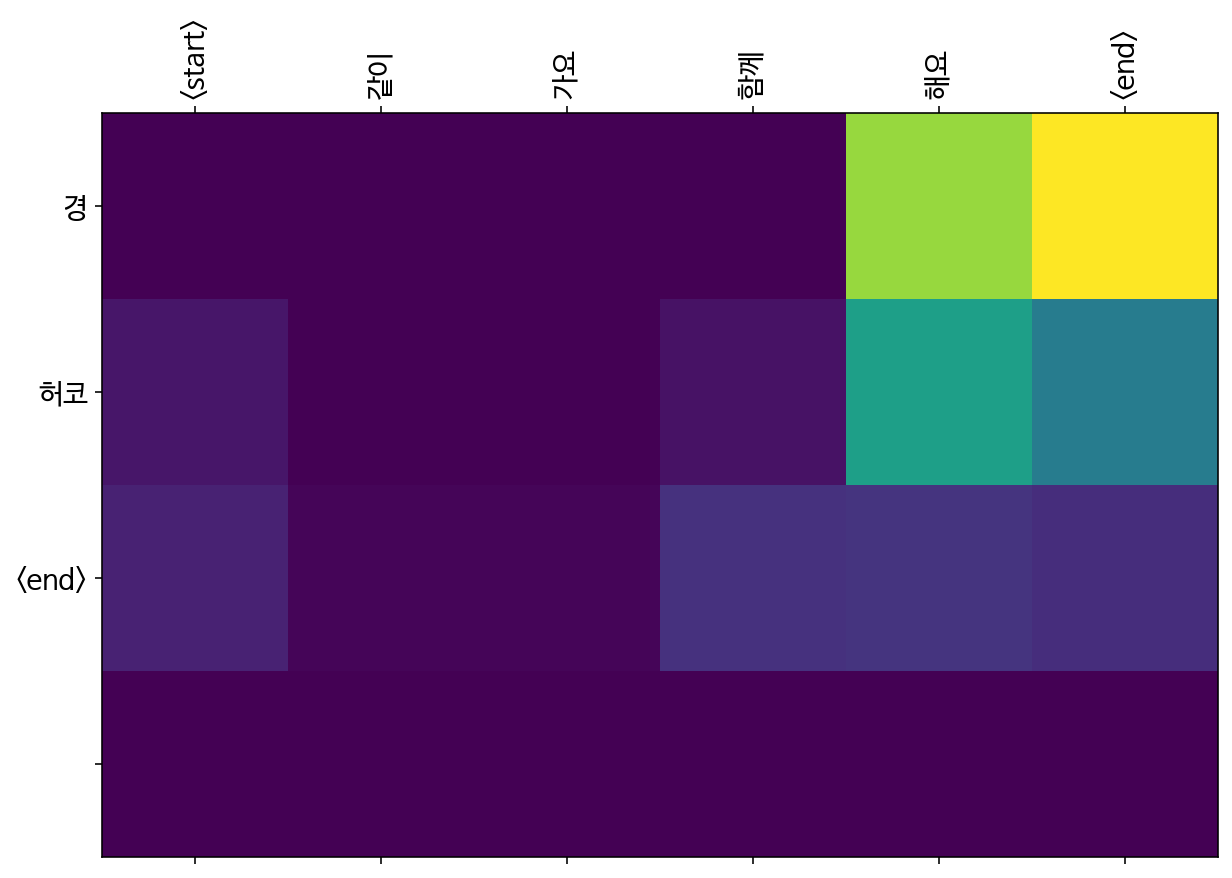

In [29]:
data_path = '/content/test.txt'

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n') # 각 문장. 일단 줄바꿈으로 한줄씩 불러옴

print(lines)

translate(lines[0])

Input: <start> 너와 함께 하면 즐거움이 열배야 <end>
Predicted translation: 경 허코 <end> 


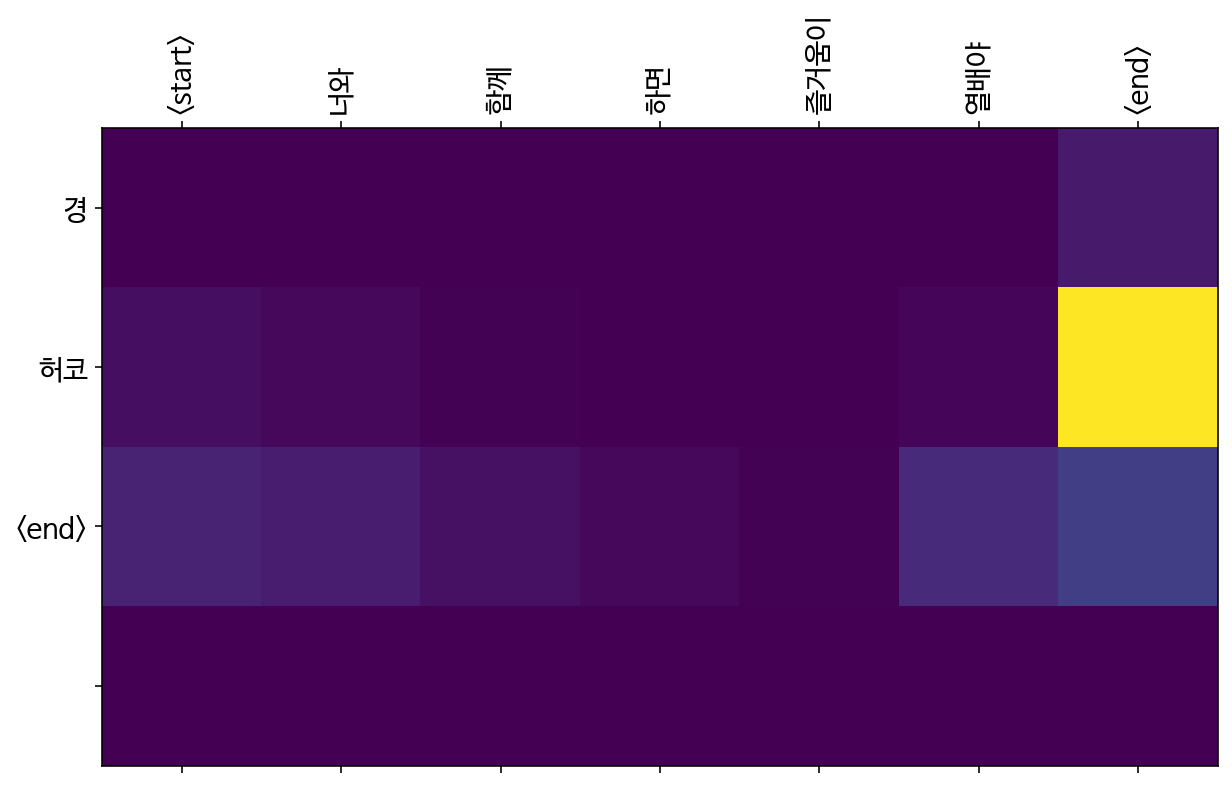

In [30]:
translate(lines[1])

Input: <start> 같이 가요 함께 해요 <end>
Predicted translation: 경 허코 <end> 


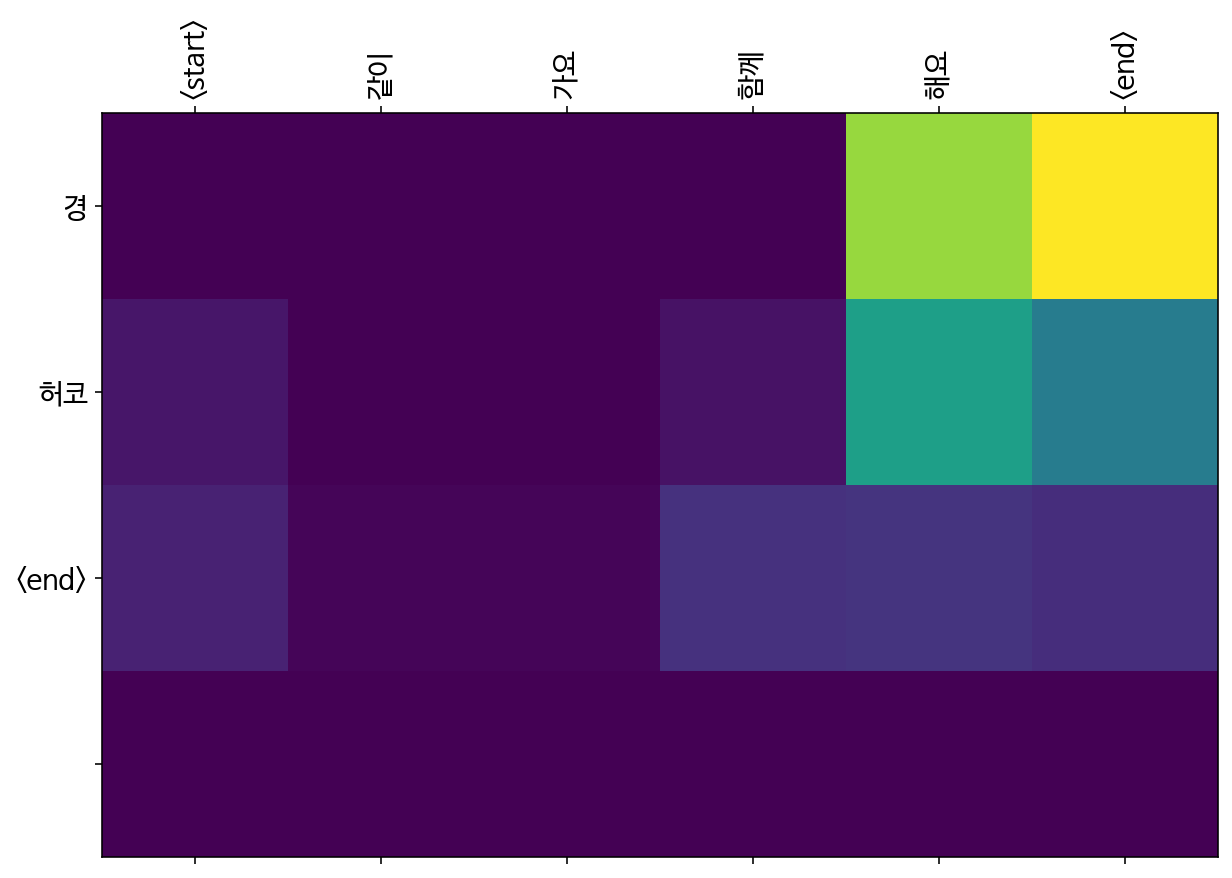

In [31]:
translate(lines[2])

Input: <start> 너와 함께 하면 즐거움이 백배야 <end>
Predicted translation: 경 호멍. <end> 


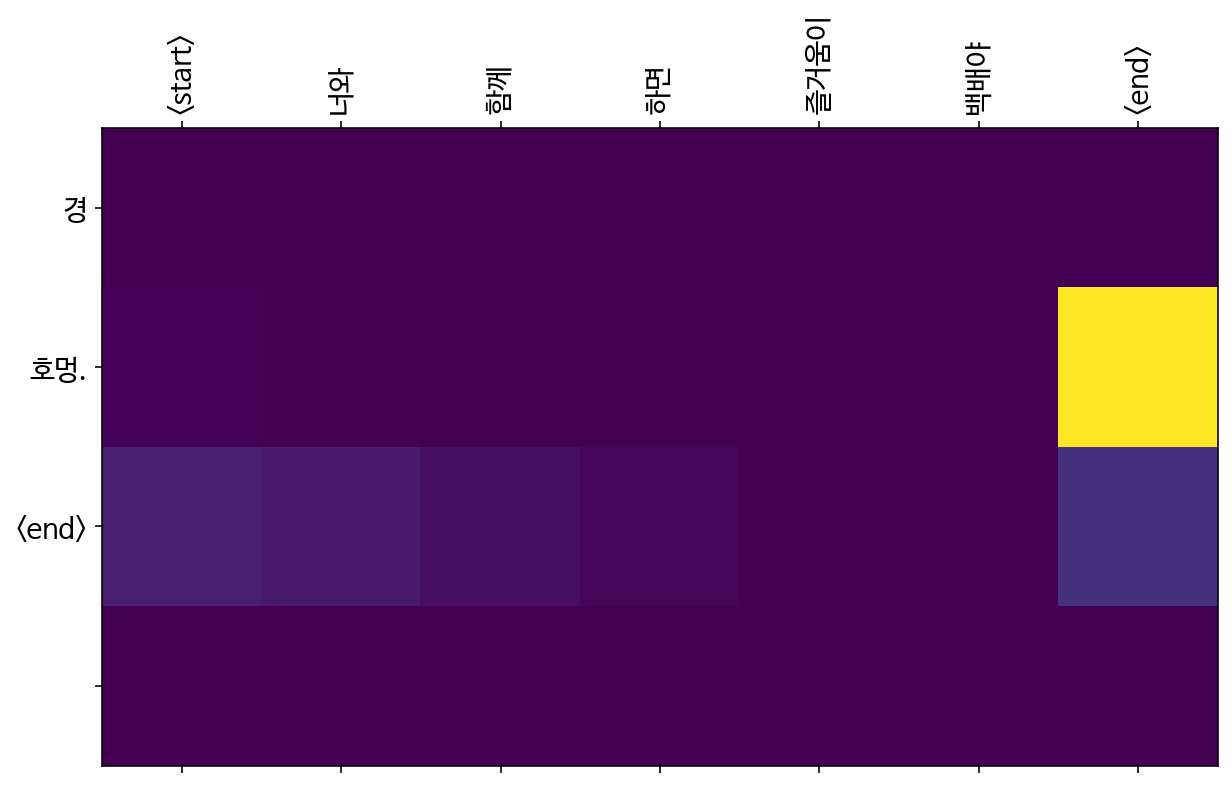

In [32]:
translate(lines[3])

Input: <start> 이렇게 예쁜 날 공기 좋고 사람 좋고 <end>
Predicted translation: 경 옵서게. <end> 


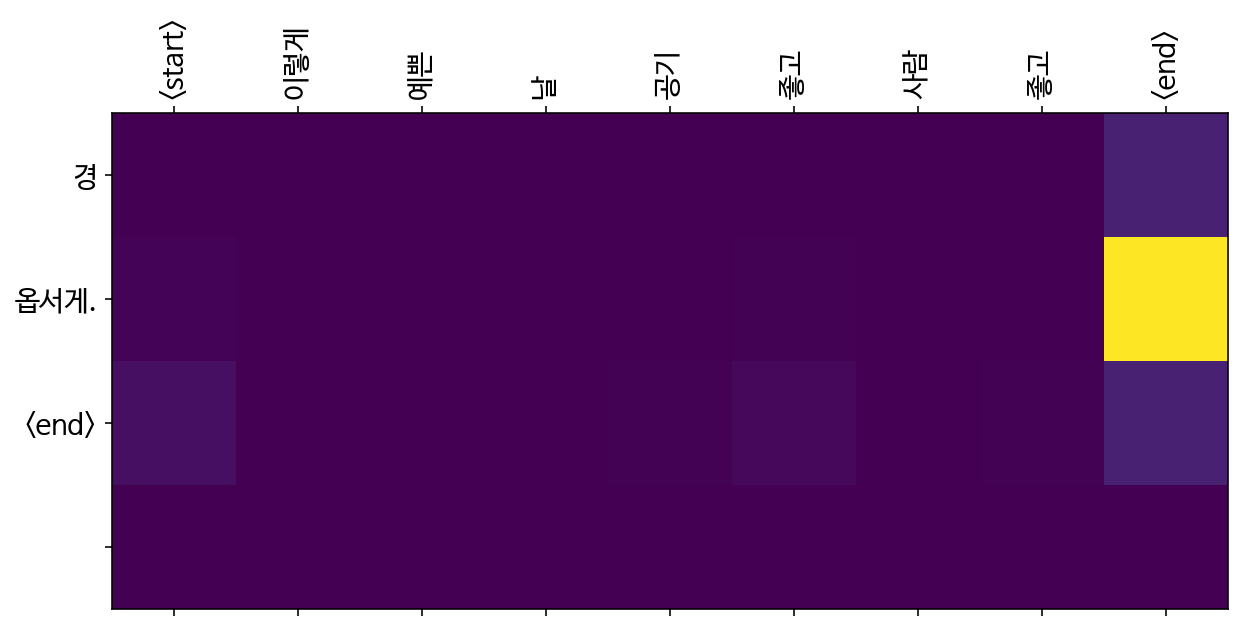

In [33]:
translate(lines[4])

Input: <start> 너와 함께 하니 무슨 걱정 있으랴 <end>
Predicted translation: 경 호멍. <end> 


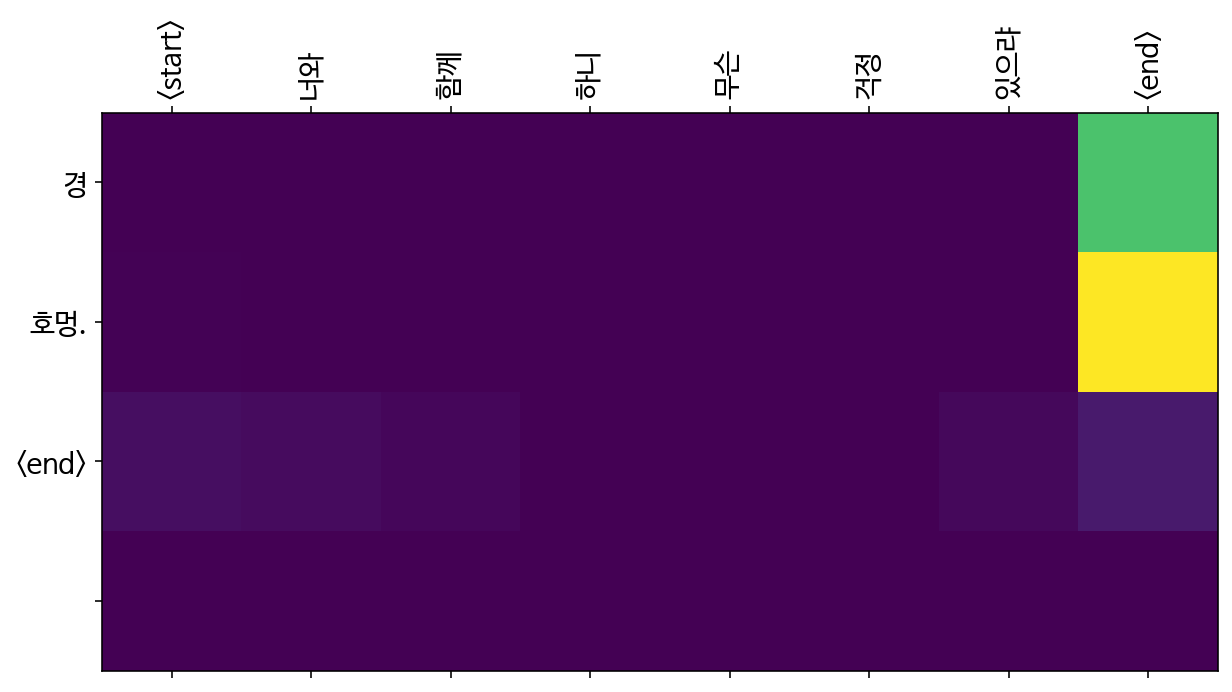

In [34]:
translate(lines[5])

Input: <start> 많이 말하면 잔소리야 <end>
Predicted translation: 경 허코 <end> 


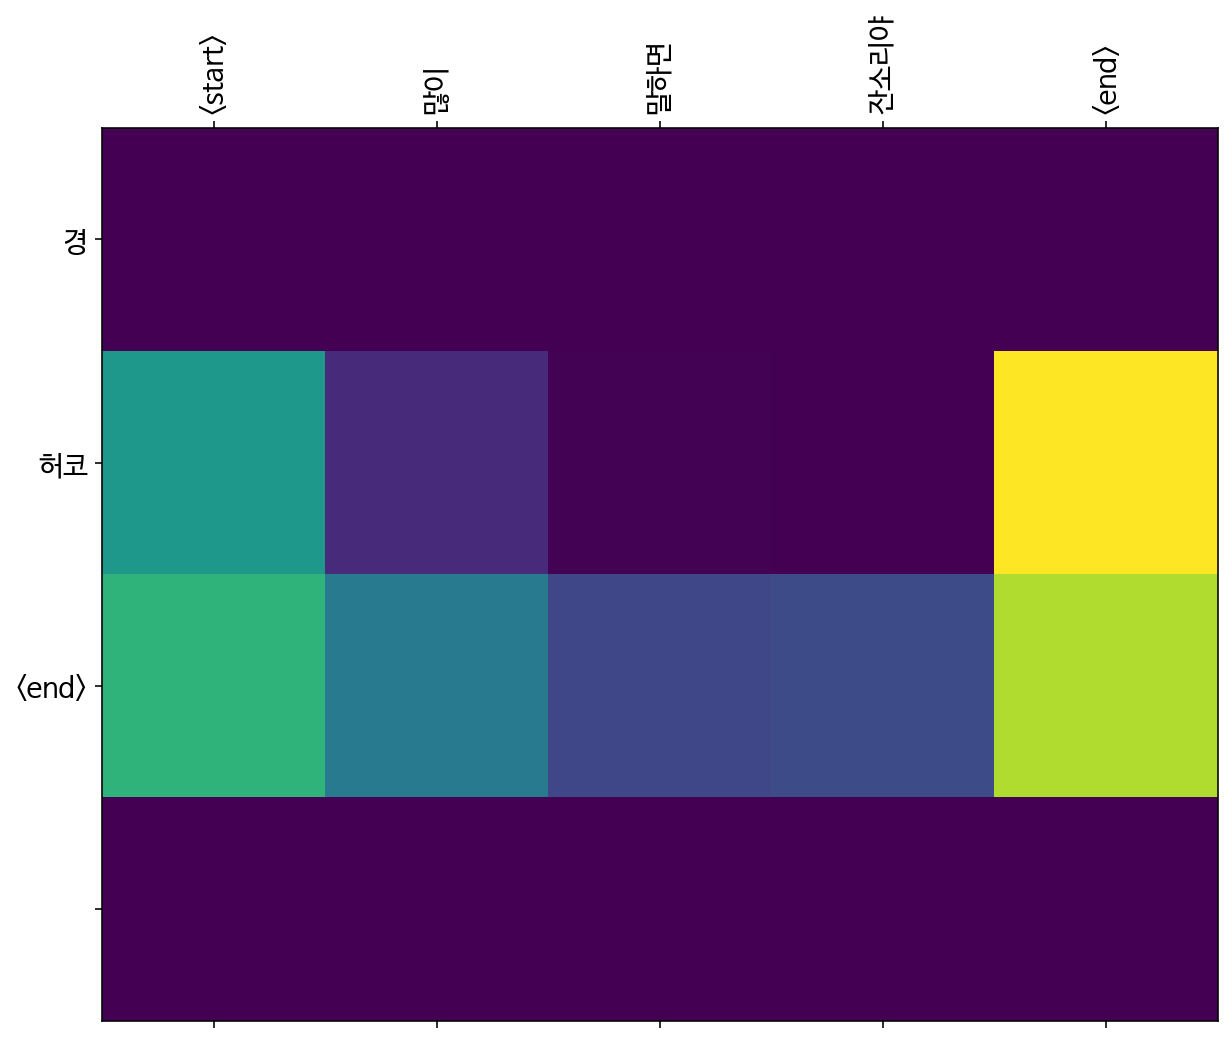

In [35]:
translate(lines[6])

## Next steps

* [Download a different dataset](http://www.manythings.org/anki/) to experiment with translations, for example, English to German, or English to French.
* Experiment with training on a larger dataset, or using more epochs
